In [12]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install yahooquery

Note: you may need to restart the kernel to use updated packages.


In [14]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

from re import search
from yahooquery import Screener

In [15]:
def getRates(ticker_input ,period_input  ,interval_input ):
    print(ticker_input+" "+period_input+" "+interval_input )
    data = yf.download(tickers=ticker_input, period = period_input, interval = interval_input)
    return data["Close"]

In [16]:
def getPercChange(d):
    x=round(d.head(1),6).values
    y=round(d.tail(1),6).values
    perc_chg= np.round( (  (y-x) / abs(x)  ) *100  , 4)
    return perc_chg

In [17]:
def mail2me(pair_text,message_text):
    from email.message import EmailMessage
    import smtplib
    from pretty_html_table import build_table

    sender = "ozukun83@gmail.com"
    recipient = "ozukun83@gmail.com"
    message = "Crypto Info all"

    password = input("Type your password and press enter: ")
    
    email = EmailMessage()
    email["From"] = sender
    email["To"] = recipient
    email["Subject"] = "Crypto Rates Python!"+"  "+pair_text
    email.set_content(message_text)

    
    
    smtp = smtplib.SMTP_SSL("smtp.gmail.com")
    smtp.login(sender, password)
    smtp.sendmail(sender, recipient, email.as_string())
    smtp.quit()
    print("Mail succeed !!")

In [41]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=100)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [44]:
# moving average
def get_ma(prices, rate):
    return prices.rolling(rate).mean()



def get_bollinger_bands(prices, rate=7):
    sma = get_ma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down


def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    
    macd = pd.DataFrame(exp1 - exp2)
    macd.columns=["macd"]
    
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean())
    signal.columns=["signal"]
    
    hist = pd.DataFrame(macd['macd'] - signal['signal'])
    hist.columns=["hist"]
    
    
    
    frames =  [macd, signal, hist]
    
    
    
    df = pd.concat(frames, join = 'inner', axis = 1)
    df["result"]= np.select([df.macd > df.signal , df.macd < df.signal], ["Buy", "Sell"])
    return df




#HISTOGRAM = MACD LINE - SIGNAL LINE

#IF MACD LINE > SIGNAL LINE => BUY THE STOCK
#IF SIGNAL LINE > MACD LINE => SELL THE STOCK

#---------------------------------------------------------------


df_tmp_f = pd.DataFrame()
df_buy_signal=pd.DataFrame()
final_text=""
#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cpx in getCryptoPairs():
    Crypto_Pairs.append(cpx)


for cp in Crypto_Pairs:

    df_tmp_0 = pd.DataFrame(getRates(cp,  '1y',  '1d'))

    bollinger_up, bollinger_down = get_bollinger_bands(df_tmp_0)

    cp_macd=get_macd(getRates(cp,  '1y',  '1d'), 26, 12, 9)
    
    #display(cp_macd.iloc[-7:])

    df_tmp = pd.DataFrame(data=np.column_stack((df_tmp_0.values,bollinger_up,bollinger_down,cp_macd.macd,
                                                cp_macd.signal,cp_macd.result )),
                          columns=['Price','Bol_Up','Bol_Down',"macd","signal","result"])
    df_tmp.insert(0,'Crypto_Pair',cp)
    df_tmp.index=df_tmp_0.index


    #display( df_tmp.iloc[-7:] )
    
    x=round( df_tmp["Bol_Up"].iloc[-90:].mean() ,6 )
    #print("Bol_Up__Mean_for_last_7days   : " + str( x ) )
    
    
    y=round( df_tmp["Bol_Down"].iloc[-90:].mean() ,6 )
    #print("Bol_Down__Mean_for_last_7days : " + str( y ) )
    
    
    df_tmp_2 = pd.DataFrame(data=np.column_stack((cp,df_tmp.iloc[-1].Price,x,y )),
                          columns=["Crypto_Pair",'Price','Bol_Up_30','Bol_Down_30'])
    
    
    #display( df_tmp_2["Bol_Up_30"].values )
    
    x1="Bol_Up__Mean_for_last_7days   : " + str( x )
    y1="Bol_Down__Mean_for_last_7days : " + str( y )
    
    df_tmp_f = df_tmp_f.append(df_tmp.iloc[-7:])
    final_text=final_text+"\n"+cp+"\n"+str(x1)+"\n"+str(y1)
    r0=df_tmp.iloc[-1].Price
    r1= ( df_tmp.iloc[-1].Price+(df_tmp.iloc[-1].Price*0.05) ) 
    r2=float(df_tmp_2["Bol_Up_30"].values) 
    df_tmp_2["%change"]=((r2-r0)/ abs(r0) ) *100
    #print(r1)
    #print(r2)
    if r1<=r2:
        print("BUY_signal")
        df_buy_signal=df_buy_signal.append(df_tmp_2)
        #display(df_buy_signal)
        
#---------------------------------------------------------------------------
#display(df_buy_signal)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands",final_text)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands","")

BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BUSD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BUSD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
DO

In [43]:
display(df_buy_signal) 

,Crypto_Pair,Price,Bol_Up_30,Bol_Down_30,%change
0,LEO-USD,3.360255002975464,3.965389,3.567701,12.389118
0,LUNC-USD,0.00017046704306267202,0.000188,0.000151,5.033569
0,HT-USD,5.807141304016113,6.279402,5.108392,2.983250
0,CHZ-USD,0.14054813981056213,0.176057,0.133031,19.299575
0,BSV-USD,42.76591873168945,45.244754,40.308413,0.758368
0,BTT-USD,7.460224082933564e-07,1e-06,1e-06,27.661172
0,TWT-USD,1.6568901538848877,1.966595,1.495425,13.039939
0,FTT-USD,1.9308091402053833,4.598686,1.426054,126.832412


In [21]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=10)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [22]:
def getRatesTable(*args):
    df_table = pd.DataFrame()
    for cp in args:
        df10yr=getRates(cp, '10y',  '1d')
        df5yr=getRates(cp,  '5y',  '1d')
        df3yr=getRates(cp,  '3y',  '1d')
        df1yr=getRates(cp,  '1y',  '1d')
        df3mo=getRates(cp,  '3mo',  '1h')
        df1mo=getRates(cp,  '1mo',  '1h')
        df1wk=getRates(cp,  '1wk',  '1h')
        df1dy=getRates(cp,  '1dy',  '1h')
        new_row = pd.Series(data={
                                   'Crypto_Pair':cp,
                                   '10yr_d_CHG%':getPercChange(df10yr)[0],
                                   '5yr_d_CHG%':getPercChange(df5yr)[0],
                                   '3yr_d_CHG%':getPercChange(df3yr)[0],
                                   '1yr_d_CHG%':getPercChange(df1yr)[0], 
                                   '3mo_h_CHG%':getPercChange(df3mo)[0], 
                                   '1mo_h_CHG%':getPercChange(df1mo)[0] ,
                                   '1wk_h_CHG%':getPercChange(df1wk)[0],
                                   '1dy_h_CHG%':getPercChange(df1dy)[0], 
                                 } 
                           )
        
        df_table = df_table.append(new_row, ignore_index=True)
    return df_table

#--------------------------------------------------------------------


#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cp in getCryptoPairs():
    Crypto_Pairs.append(cp)

dfx=getRatesTable(*Crypto_Pairs)

#dfx

BTC-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 complete

In [23]:
display(df_buy_signal)

""


In [24]:
def mail2me_v2(df,mail_subject,message_text):
    
    from email.mime.text import MIMEText
    from email.mime.application import MIMEApplication
    from email.mime.multipart import MIMEMultipart
    from smtplib import SMTP
    import smtplib
    import sys


    recipients = ['ozukun83@gmail.com'] 
    emaillist = [elem.strip().split(',') for elem in recipients]
    msg = MIMEMultipart()
    msg['Subject'] = mail_subject
    msg['From'] = 'ozukun83@gmail.com'

    password = input("Type your password and press enter: ")
    

    html = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(df.to_html())

    part1 = MIMEText(html, 'html')
    msg.attach(part1)
    body = message_text
    body = MIMEText(body) # convert the body to a MIME compatible string
    msg.attach(body)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.ehlo()
    server.login("ozukun83@gmail.com",password)
    server.sendmail(msg['From'], emaillist , msg.as_string())
    print("Mail succeed !!")
    
#---------------------------------------------------------------------------
#mail2me_v2(dfx,"Crypto Rate changes","")

ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed


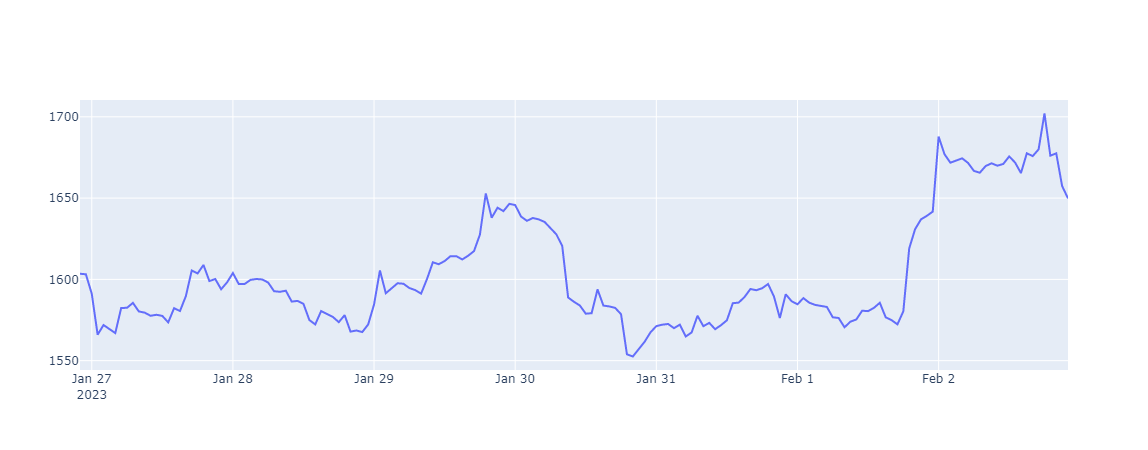

ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


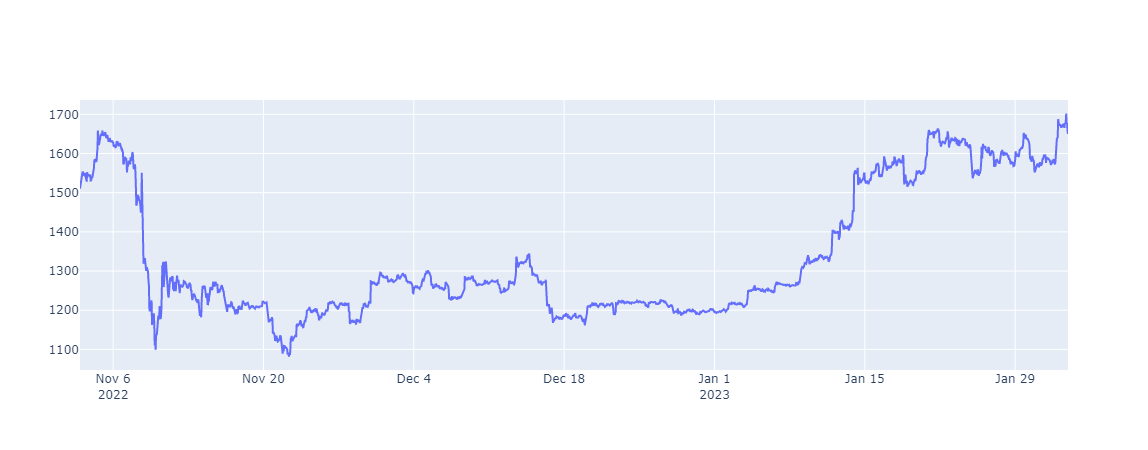

In [25]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def getLine(df_input):
    x = df_input.index
    y = df_input.values
    fig = go.Figure(data=go.Scatter(x = x, y = y))
    fig.show()
    
#------------------------------------------------

#( getLine(getRates('ETH-USD',  '1d',  '1h')) )
( getLine(getRates('ETH-USD',  '1wk',  '1h')) )
( getLine(getRates('ETH-USD',  '3mo',  '1h')) )
#( getLine(getRates('ETH-USD',  '3y',  '1d')) )

In [26]:

html = dfx.to_html()
# Write the HTML to a file
with open('crypto_change.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,10yr_d_CHG%,5yr_d_CHG%,3yr_d_CHG%,1yr_d_CHG%,3mo_h_CHG%,1mo_h_CHG%,1wk_h_CHG%,1dy_h_CHG%
0,BTC-USD,5049.1329,166.6675,152.0100,-36.2738,17.1411,40.9356,2.2586,-2.5245
1,ETH-USD,414.1536,80.1555,774.6994,-38.5044,9.2439,35.7437,2.8915,-2.2521
2,BNB-USD,16313.4158,3285.2418,1671.1951,-11.0807,2.2517,32.6163,7.1601,1.5658
3,XRP-USD,88.6449,-53.6294,63.6316,-31.7886,-8.9319,17.4864,-0.0789,-1.5723
4,BUSD-USD,-0.1722,-0.1722,-0.2365,0.1046,-0.0018,-0.0672,-0.0524,-0.0531
5,ADA-USD,1147.7147,2.4059,617.1317,-61.1306,4.2323,57.3654,5.1244,-1.2628
6,DOGE-USD,6355.7597,1941.3184,3601.3371,-33.4361,-27.7479,26.8313,6.1161,-4.5435
7,MATIC-USD,26774.0556,26774.0556,6115.5480,-22.9448,39.4628,51.8745,6.9699,-4.6714


In [27]:
html = df_tmp_f.to_html()
# Write the HTML to a file
with open('crypto_bol.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-27 00:00:00+00:00,BTC-USD,23078.728516,23278.260675,22521.255508,1479.983433,1351.706473,Buy
2023-01-28 00:00:00+00:00,BTC-USD,23031.089844,23308.391907,22563.542803,1444.084486,1370.182076,Buy
2023-01-29 00:00:00+00:00,BTC-USD,23774.566406,23772.654762,22400.465774,1458.810399,1387.90774,Buy
2023-01-30 00:00:00+00:00,BTC-USD,22840.138672,23776.604259,22369.575428,1379.181931,1386.162579,Sell
2023-01-31 00:00:00+00:00,BTC-USD,23139.283203,23733.718633,22556.122326,1324.941164,1373.918296,Sell
2023-02-01 00:00:00+00:00,BTC-USD,23723.769531,23962.648041,22500.310106,1313.971481,1361.928933,Sell
2023-02-02 00:00:00+00:00,BTC-USD,23561.615234,24051.548132,22562.506555,1277.467581,1345.036662,Sell
2023-01-27 00:00:00+00:00,ETH-USD,1598.156494,1659.039339,1556.197547,83.55157,86.496093,Sell
2023-01-28 00:00:00+00:00,ETH-USD,1572.435059,1653.946001,1545.667141,77.432811,84.683437,Sell


In [28]:
from datetime import timedelta
df_ALGO = pd.DataFrame(getRates('ALGO-USD',  '10y',  '1d'))
date=df_ALGO.index[-1]+ timedelta(days=1)

print(df_ALGO)

df_ALGO.loc[date, :] = [0]


print(df_ALGO.size)

df_ALGO['S1'] = df_ALGO['Close'].shift(1)
df_ALGO['SMA3'] = df_ALGO['Close'].rolling(3).mean().shift(1)
df_ALGO['SMA5'] = df_ALGO['Close'].rolling(5).mean().shift(1)
df_ALGO['SMA15'] = df_ALGO['Close'].rolling(15).mean().shift(1)
df_ALGO['SMA30'] = df_ALGO['Close'].rolling(30).mean().shift(1)

df_ALGO['S1'] = df_ALGO['S1'].fillna(0)
df_ALGO['SMA3'] = df_ALGO['SMA3'].fillna(0)
df_ALGO['SMA5'] = df_ALGO['SMA5'].fillna(0)
df_ALGO['SMA15'] = df_ALGO['SMA15'].fillna(0)
df_ALGO['SMA30'] = df_ALGO['SMA30'].fillna(0)



X = df_ALGO.iloc[:, 1:-1].values
y = df_ALGO.iloc[:, 0].values



df_ALGO

ALGO-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
                              Close
Date                               
2019-06-21 00:00:00+00:00  3.201412
2019-06-22 00:00:00+00:00  2.158967
2019-06-23 00:00:00+00:00  1.890702
2019-06-24 00:00:00+00:00  1.383728
2019-06-25 00:00:00+00:00  1.537290
...                             ...
2023-01-29 00:00:00+00:00  0.262193
2023-01-30 00:00:00+00:00  0.239771
2023-01-31 00:00:00+00:00  0.242206
2023-02-01 00:00:00+00:00  0.251032
2023-02-02 00:00:00+00:00  0.257359

[1323 rows x 1 columns]
1324


,Close,S1,SMA3,SMA5,SMA15,SMA30
Date,,,,,,
2019-06-21 00:00:00+00:00,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-22 00:00:00+00:00,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000
2019-06-23 00:00:00+00:00,1.890702,2.158967,0.000000,0.000000,0.000000,0.000000
2019-06-24 00:00:00+00:00,1.383728,1.890702,2.417027,0.000000,0.000000,0.000000
2019-06-25 00:00:00+00:00,1.537290,1.383728,1.811132,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2023-01-30 00:00:00+00:00,0.239771,0.262193,0.258074,0.253080,0.240676,0.218618
2023-01-31 00:00:00+00:00,0.242206,0.239771,0.253089,0.251960,0.240638,0.220850
2023-02-01 00:00:00+00:00,0.251032,0.242206,0.248057,0.251240,0.241166,0.223008


In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Dense



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)


ann=tf.keras.Sequential()
ann.add(tf.keras.layers.Dense(units=12,
                              activation="relu"))

ann.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
ann.compile(loss='mean_squared_error', optimizer='adam' ,metrics=['mse'])

# Fitting the ANN to the Training set
ann.fit(X_train, y_train ,batch_size = 50, epochs = 1000)



2023-02-02 22:34:06.056736: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-02 22:34:06.195430: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
24/24 [==============================] - 1s 2ms/step - loss: 0.8092 - mse: 0.8092
Epoch 2/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.6340 - mse: 0.6340
Epoch 3/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.4353 - mse: 0.4353
Epoch 4/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2387 - mse: 0.2387
Epoch 5/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.0962 - mse: 0.0962
Epoch 6/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0426 - mse: 0.0426
Epoch 7/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0345 - mse: 0.0345
Epoch 8/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0320 - mse: 0.0320
Epoch 9/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.0297 - mse: 0.0297
Epoch 10/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.0275 - mse: 0.0275
Epoch 11/1000
24/24 [============================

In [30]:
y_test[:-1]

array([0.383968  , 0.38886899, 0.36813301, 0.35306299, 0.34916401,
       0.354938  , 0.35242099, 0.35509601, 0.35426599, 0.354747  ,
       0.35740799, 0.35380101, 0.34868899, 0.341346  , 0.33428901,
       0.338705  , 0.32015499, 0.317395  , 0.31430599, 0.31931499,
       0.31733701, 0.31928501, 0.32267201, 0.33011401, 0.31950101,
       0.307179  , 0.30699301, 0.312841  , 0.31345099, 0.315698  ,
       0.31445   , 0.331707  , 0.339315  , 0.32674801, 0.33378699,
       0.33867699, 0.35925701, 0.359101  , 0.36001799, 0.36157301,
       0.36922199, 0.41486999, 0.42339   , 0.404138  , 0.41834399,
       0.33228999, 0.26510599, 0.31977201, 0.302286  , 0.27337599,
       0.26217699, 0.260948  , 0.28126699, 0.27616799, 0.26797599,
       0.29757699, 0.298621  , 0.25611299, 0.245101  , 0.24059901,
       0.246718  , 0.24211399, 0.2436    , 0.240537  , 0.240466  ,
       0.235966  , 0.240555  , 0.2483    , 0.240749  , 0.244508  ,
       0.23791599, 0.24011201, 0.236687  , 0.23409399, 0.22157

In [31]:
import sklearn.metrics

predictions = ann.predict(X_test)
mse_no=sklearn.metrics.mean_squared_error(y_test[:-1],predictions[:-1])

print(mse_no)

print(y_test[-7:])
print(predictions[-7:])



0.0006991080266744022
[0.25730199 0.26219299 0.23977099 0.24220601 0.25103199 0.25735918
 0.        ]
[[0.2557656 ]
 [0.25907248]
 [0.26471788]
 [0.24535877]
 [0.24468338]
 [0.24930245]
 [0.25628456]]


In [32]:
type( y_test[-7:] )

print(y_test[-7:].shape)
print(predictions[-7:].shape)

z=y_test[-7:].reshape(7,1)

print(z.shape)

final=np.hstack((z,predictions[-7:] ))

final

(7,)
(7, 1)
(7, 1)


array([[0.25730199, 0.25576559],
       [0.26219299, 0.25907248],
       [0.23977099, 0.26471788],
       [0.24220601, 0.24535877],
       [0.25103199, 0.24468338],
       [0.25735918, 0.24930245],
       [0.        , 0.25628456]])

In [33]:
from datetime import datetime
# create an index list object
timestamp_list = pd.date_range(df_ALGO.index[-7], periods=7).tolist()

# create new dataframe
x1=pd.DataFrame(final, columns=["real","predict"],index=timestamp_list)
x1['diff'] = x1['real'] - (x1['predict'])
x1

,real,predict,diff
2023-01-28 00:00:00+00:00,0.257302,0.255766,0.001536
2023-01-29 00:00:00+00:00,0.262193,0.259072,0.003121
2023-01-30 00:00:00+00:00,0.239771,0.264718,-0.024947
2023-01-31 00:00:00+00:00,0.242206,0.245359,-0.003153
2023-02-01 00:00:00+00:00,0.251032,0.244683,0.006349
2023-02-02 00:00:00+00:00,0.257359,0.249302,0.008057
2023-02-03 00:00:00+00:00,0.000000,0.256285,-0.256285


In [34]:
#LTSM RNN

df_alg = pd.DataFrame(getRates('ALGO-USD',  '10y',  '1d'))

df_alg['Close_1']=df_alg['Close'].shift(1)

df_alg=df_alg.fillna(0)


print(df_alg.shape[1])

display(df_alg)

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

ALGO-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
2


,Close,Close_1
Date,,
2019-06-21 00:00:00+00:00,3.201412,0.000000
2019-06-22 00:00:00+00:00,2.158967,3.201412
2019-06-23 00:00:00+00:00,1.890702,2.158967
2019-06-24 00:00:00+00:00,1.383728,1.890702
2019-06-25 00:00:00+00:00,1.537290,1.383728
...,...,...
2023-01-29 00:00:00+00:00,0.262193,0.257302
2023-01-30 00:00:00+00:00,0.239771,0.262193
2023-01-31 00:00:00+00:00,0.242206,0.239771
